# Clone repo for datasets, Install DeepXDE via pip

In [1]:
!git clone https://github.com/ianbgroves/PatternLearning/


Cloning into 'PatternLearning'...
remote: Enumerating objects: 618, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 618 (delta 0), reused 0 (delta 0), pack-reused 612
Receiving objects: 100% (618/618), 525.17 MiB | 26.20 MiB/s, done.
Resolving deltas: 100% (21/21), done.
Updating files: 100% (578/578), done.


In [2]:
pip install deepxde

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.8/156.8 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 14.8 MB/s eta 0:00:00


# Poisson equation

## Imports

In [45]:
import deepxde as dde
from deepxde.backend import tf
import numpy as np

We begin by defining a computational geometry. We can use a built-in class Interval as follows

In [46]:
geom = dde.geometry.Interval(-1, 1)

Next, we express the PDE residual of the Poisson equation

The first argument to pde is the network input, i.e., the x
-coordinate. The second argument is the network output, i.e., the solution u(x)
, but here we use y as the name of the variable.

$-\frac{{\partial^2 y}}{{\partial x^2}} = \pi^2 \sin(\pi x)$

In [47]:
def pde(x, y):
    dy_xx = dde.grad.hessian(y, x)
    return -dy_xx - np.pi ** 2 * tf.sin(np.pi * x)

Next, we consider the Dirichlet boundary condition. A simple Python function, returning a boolean, is used to define the subdomain for the Dirichlet boundary condition ({−1,1}
). The function should return True for those points inside the subdomain and False for the points outside. In our case, the points x
 of the Dirichlet boundary condition are x=−1
 and x=1
. (Note that because of rounding-off errors, it is often wise to use dde.utils.isclose to test whether two floating point values are equivalent.)

In [48]:
def boundary(x, _):
    return dde.utils.isclose(x[0], -1) or dde.utils.isclose(x[0], 1)

The argument x to

```
boundary()
```

is the network input and is a d
-dim vector, where d
 is the dimension and d=1
 in this case. To facilitate the implementation of boundary, a boolean on_boundary is used as the second argument. If the point x (the first argument) is on the entire boundary of the geometry (the left and right endpoints of the interval in this case), then on_boundary is True, otherwise, on_boundary is False. Thus, we can also define boundary in a simpler way:

In [49]:
def func(x):
    return 0

Next, we define a function to return the value of u(x)
 for the points x
 on the boundary. In this case, it is u(x)=0
.
\
If the function value is not a constant, we can also use NumPy to compute. For example, sin(πx)
 is 0 on the boundary, and thus we can also use

In [50]:
def func(x):
    return np.sin(np.pi * x)

Then, the Dirichlet boundary condition is

In [51]:
bc = dde.icbc.DirichletBC(geom, func, boundary)

Now, we have specified the geometry, PDE residual, and Dirichlet boundary condition. We then define the PDE problem as

In [52]:
data = dde.data.PDE(geom,
                    pde,
                    bc,
                    16, # number of collocation points sampled within the domain
                    2, # number of boundary training data (number of boundaries perhaps?)
                    solution=func, # reference solution (ground truth)
                    num_test=100 #number of residual (collocation) points to test the PDE
                    )

The number 16 is the number of training residual points sampled inside the domain, and the number 2 is the number of training points sampled on the boundary. The argument solution=func is the reference solution to compute the error of our solution, and can be ignored if we don’t have a reference solution. We use 100 residual points for testing the PDE residual.

Next, we choose the network. Here, we use a fully connected neural network of depth 4 (i.e., 3 hidden layers) and width 50:

In [53]:
layer_size = [1] + [50] * 5 + [1] # input/output shape is 1
activation = "tanh"
initializer = "Glorot uniform" #how the weights are initialised - this could be an important optimisation step, potential for transfer learning
net = dde.nn.FNN(layer_size, activation, initializer)

Now, we have the PDE problem and the network. We build a Model and choose the optimizer and learning rate:

In [54]:
model = dde.Model(data, net)
model.compile("adam", lr=0.001, metrics=["l2 relative error"])

Compiling model...
Building feed-forward neural network...
'build' took 0.089276 s



/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 0.760423 s



We also compute the L2
 relative error as a metric during training. We can also use callbacks to save the model and the movie during training, which is optional.


In [ ]:
!apt install imagemagick

Reading package lists... Done
Building dependency tree       
Reading state information... Done
imagemagick is already the newest version (8:6.9.10.23+dfsg-2.1ubuntu11.7).
0 upgraded, 0 newly installed, 0 to remove and 13 not upgraded.


In [55]:
checkpointer = dde.callbacks.ModelCheckpoint(
    "model/model.ckpt", verbose=1, save_better_only=True
)
# ImageMagick (https://imagemagick.org/) is required to generate the movie.
movie = dde.callbacks.MovieDumper(
    "model/movie", [-1], [1], period=100, save_spectrum=True, y_reference=func
)

We then train the model for 10000 iterations:

In [56]:
losshistory, train_state = model.train(
    iterations=10000, callbacks=[checkpointer, movie]
)

Training model...

Step      Train loss              Test loss               Test metric   
0         [4.40e+01, 4.45e-03]    [4.98e+01, 4.45e-03]    [9.64e-01]    
Epoch 1: train loss improved from inf to 4.40e+01, saving model to model/model.ckpt-1.ckpt ...

1000      [3.90e-04, 7.41e-07]    [3.98e-04, 7.41e-07]    [6.46e-04]    
Epoch 1000: train loss improved from 4.40e+01 to 3.91e-04, saving model to model/model.ckpt-1000.ckpt ...

2000      [1.02e-03, 6.28e-05]    [7.11e-04, 6.28e-05]    [6.41e-03]    
3000      [8.69e-05, 4.77e-07]    [1.72e-04, 4.77e-07]    [6.23e-04]    
Epoch 3000: train loss improved from 3.91e-04 to 8.74e-05, saving model to model/model.ckpt-3000.ckpt ...

4000      [8.44e-03, 5.38e-04]    [6.08e-03, 5.38e-04]    [1.67e-02]    
5000      [3.68e-03, 1.75e-04]    [3.17e-03, 1.75e-04]    [1.31e-02]    
6000      [1.35e-03, 5.34e-05]    [1.02e-03, 5.34e-05]    [4.83e-03]    
7000      [5.45e-05, 5.57e-06]    [1.26e-04, 5.57e-06]    [1.82e-03]    
Epoch 7000: tr

In [57]:
def _pack_data(train_state):
    def merge_values(values):
        if values is None:
            return None
        return np.hstack(values) if isinstance(values, (list, tuple)) else values

    y_train = merge_values(train_state.y_train)
    y_test = merge_values(train_state.y_test)
    best_y = merge_values(train_state.best_y)
    best_ystd = merge_values(train_state.best_ystd)
    return y_train, y_test, best_y, best_ystd


In [58]:
y_train, y_test, best_y, best_ystd = _pack_data(train_state)
y_dim = best_y.shape[1]

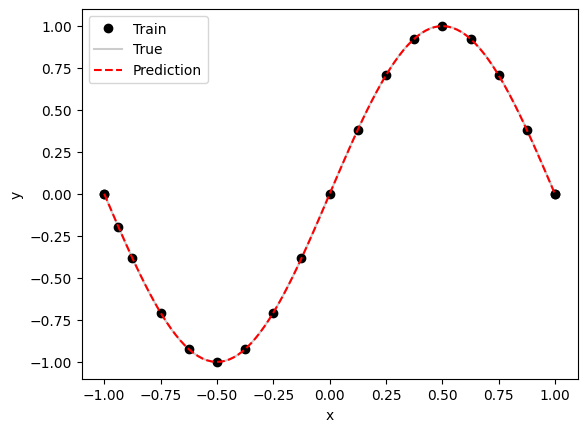

In [59]:
# 1D plot the training points
if train_state.X_test.shape[1] == 1:
    idx = np.argsort(train_state.X_test[:, 0])
    X = train_state.X_test[idx, 0]
    plt.figure()
    for i in range(y_dim):
        if y_train is not None:
            plt.plot(train_state.X_train[:, 0], y_train[:, i], "ok", label="Train")

# 1D plot the validation points
if y_test is not None:
    plt.plot(X, y_test[idx, i], "-k", label="True", alpha=0.2)

# 1D plot the predicted curve
plt.plot(X, best_y[idx, i], "--r", label="Prediction")


plt.xlabel("x")
plt.ylabel("y")
plt.legend()

# Burgers eq

Compiling model...
Building feed-forward neural network...
'build' took 0.069600 s

'compile' took 1.029118 s

Training model...

0         [7.07e-03, 1.36e-02, 5.75e-01]    [7.07e-03, 1.36e-02, 5.75e-01]    []  
1000      [4.06e-02, 3.75e-04, 5.50e-02]    [4.06e-02, 3.75e-04, 5.50e-02]    []  
2000      [2.95e-02, 3.12e-05, 4.25e-02]    [2.95e-02, 3.12e-05, 4.25e-02]    []  
3000      [1.07e-02, 6.96e-05, 9.90e-03]    [1.07e-02, 6.96e-05, 9.90e-03]    []  
4000      [4.02e-03, 1.30e-05, 2.12e-03]    [4.02e-03, 1.30e-05, 2.12e-03]    []  
5000      [2.60e-03, 5.92e-06, 1.17e-03]    [2.60e-03, 5.92e-06, 1.17e-03]    []  
6000      [1.86e-03, 4.53e-06, 8.70e-04]    [1.86e-03, 4.53e-06, 8.70e-04]    []  
7000      [1.32e-03, 3.76e-06, 6.31e-04]    [1.32e-03, 3.76e-06, 6.31e-04]    []  
8000      [9.79e-04, 3.43e-06, 4.61e-04]    [9.79e-04, 3.43e-06, 4.61e-04]    []  
9000      [8.06e-04, 4.07e-06, 3.65e-04]    [8.06e-04, 4.07e-06, 3.65e-04]    []  
10000     [7.02e-04, 3.57e-06, 3.06e-04]

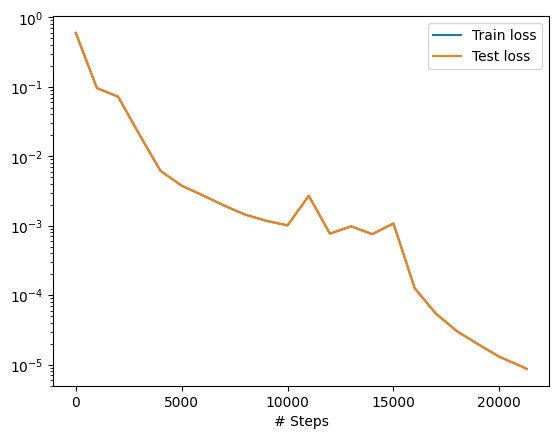

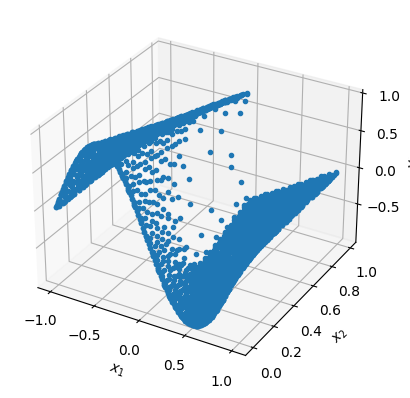

Mean residual: 0.0032518567
L2 relative error: 0.001799335934046019


In [75]:
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch"""
import deepxde as dde
import numpy as np


def gen_testdata():
    data = np.load("/content/PatternLearning/PINNs/Lu_2021_deepXDE/deep_xde_datasets/Burgers.npz")
    t, x, exact = data["t"], data["x"], data["usol"].T
    xx, tt = np.meshgrid(x, t)
    X = np.vstack((np.ravel(xx), np.ravel(tt))).T
    y = exact.flatten()[:, None]
    return X, y


def pde(x, y):
    dy_x = dde.grad.jacobian(y, x, i=0, j=0)
    dy_t = dde.grad.jacobian(y, x, i=0, j=1)
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    return dy_t + y * dy_x - 0.01 / np.pi * dy_xx


geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 0.99)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

bc = dde.icbc.DirichletBC(geomtime, lambda x: 0, lambda _, on_boundary: on_boundary)
ic = dde.icbc.IC(
    geomtime, lambda x: -np.sin(np.pi * x[:, 0:1]), lambda _, on_initial: on_initial
)

data = dde.data.TimePDE(
    geomtime, pde, [bc, ic], num_domain=2540, num_boundary=80, num_initial=160
)
net = dde.nn.FNN([2] + [20] * 3 + [1], "tanh", "Glorot normal")
model = dde.Model(data, net)

model.compile("adam", lr=1e-3)
model.train(iterations=15000)
model.compile("L-BFGS")
losshistory, train_state = model.train()
dde.saveplot(losshistory, train_state, issave=True, isplot=True)



In [87]:
X, y_true = gen_testdata()
y_pred = model.predict(X)
f = model.predict(X, operator=pde)

# Reshape the data for plotting
x_values = X[:, 0].reshape((len(np.unique(X[:, 0])), -1))
y_pred_values = y_pred.reshape((len(np.unique(X[:, 1])), -1))
y_true_values = y_true.reshape((len(np.unique(X[:, 1])), -1))

print("Shapes:")
print("X shape:", X.shape)
print("y_pred_values shape:", y_pred_values.shape)
print("y_true_values shape:", y_true_values.shape)

# Obtain the steady-state solution at t = end
t_end = np.max(X[:, 1])
print("t_end:", t_end)


# Obtain the steady-state solution at t = end
t_indices = np.where(np.isclose(X[:, 1], t_end))[0]
last_t_index = t_indices[-1]
steady_state_pred = y_pred_values[last_t_index, :]
steady_state_true = y_true_values[last_t_index, :]

# Plot the steady-state solution
plt.plot(x_values[:, 0], steady_state_pred, label="Predicted")
plt.plot(x_values[:, 0], steady_state_true, label="True")
plt.xlabel("X")
plt.ylabel("Solution")
plt.title("Steady-State Solution Prediction")
plt.legend()
plt.show()

Shapes:
X shape: (25600, 2)
y_pred_values shape: (100, 256)
y_true_values shape: (100, 256)
t_end: 0.99


IndexError: ignored

# Heat equation

Compiling model...
Building feed-forward neural network...
'build' took 0.055482 s



/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.089580 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [6.71e-02, 6.26e-02, 7.06e-01]    [6.32e-02, 6.26e-02, 7.06e-01]    []  
1000      [1.12e-03, 6.90e-04, 3.10e-04]    [7.45e-04, 6.90e-04, 3.10e-04]    []  
2000      [1.93e-04, 4.19e-05, 1.99e-05]    [1.28e-04, 4.19e-05, 1.99e-05]    []  
3000      [1.51e-04, 7.08e-05, 7.90e-05]    [1.00e-04, 7.08e-05, 7.90e-05]    []  
4000      [6.67e-05, 8.34e-06, 4.17e-06]    [4.24e-05, 8.34e-06, 4.17e-06]    []  
5000      [4.15e-05, 6.91e-06, 1.70e-06]    [2.55e-05, 6.91e-06, 1.70e-06]    []  
6000      [2.07e-05, 5.11e-06, 1.19e-06]    [1.26e-05, 5.11e-06, 1.19e-06]    []  
7000      [1.27e-05, 3.40e-06, 1.04e-06]    [7.89e-06, 3.40e-06, 1.04e-06]    []  
8000      [8.86e-06, 2.29e-06, 1.03e-06]    [5.75e-06, 2.29e-06, 1.03e-06]    []  
9000      [6.83e-06, 1.61e-06, 9.88e-07]    [4.65e-06, 1.61e-06, 9.88e-07]    []  
10000     [9.26e-06, 1.27e-06, 2.7

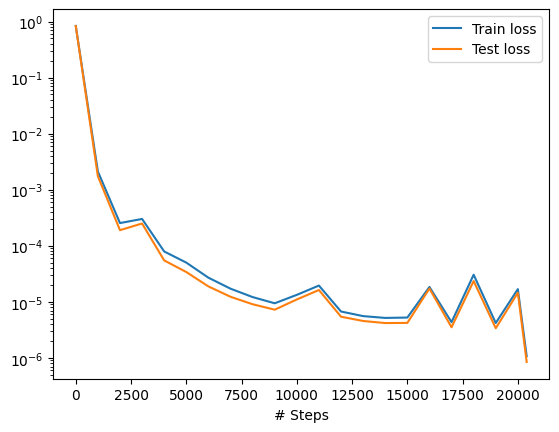

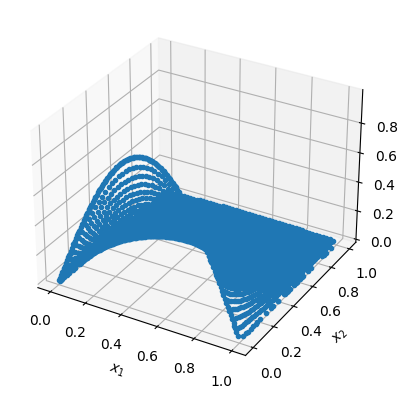

Mean residual: 0.008939908
L2 relative error: 0.7941593582475049


In [226]:
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch, paddle"""
import deepxde as dde
import numpy as np


def heat_eq_exact_solution(x, t):
    """Returns the exact solution for a given x and t (for sinusoidal initial conditions).

    Parameters
    ----------
    x : np.ndarray
    t : np.ndarray
    """
    return np.exp(-(n**2 * np.pi**2 * a * t) / (L**2)) * np.sin(n * np.pi * x / L)


def gen_exact_solution():
    """Generates exact solution for the heat equation for the given values of x and t."""
    # Number of points in each dimension:
    x_dim, t_dim = (256, 201)

    # Bounds of 'x' and 't':
    x_min, t_min = (0, 0.0)
    x_max, t_max = (L, 10.0)

    # Create tensors:
    t = np.linspace(t_min, t_max, num=t_dim).reshape(t_dim, 1)
    x = np.linspace(x_min, x_max, num=x_dim).reshape(x_dim, 1)
    usol = np.zeros((x_dim, t_dim)).reshape(x_dim, t_dim)

    # Obtain the value of the exact solution for each generated point:
    for i in range(x_dim):
        for j in range(t_dim):
            usol[i][j] = heat_eq_exact_solution(x[i], t[j])

    # Save solution:
    np.savez("heat_eq_data", x=x, t=t, usol=usol)


def gen_testdata():
    """Import and preprocess the dataset with the exact solution."""
    # Load the data:
    data = np.load("heat_eq_data.npz")
    # Obtain the values for t, x, and the excat solution:
    t, x, exact = data["t"], data["x"], data["usol"].T
    # Process the data and flatten it out (like labels and features):
    xx, tt = np.meshgrid(x, t)
    X = np.vstack((np.ravel(xx), np.ravel(tt))).T
    y = exact.flatten()[:, None]
    return X, y


# Problem parameters:
a = 0.4  # Thermal diffusivity
L = 1  # Length of the bar
n = 1  # Frequency of the sinusoidal initial conditions

# Generate a dataset with the exact solution (if you dont have one):
gen_exact_solution()


def pde(x, y):
    """Expresses the PDE residual of the heat equation."""
    dy_t = dde.grad.jacobian(y, x, i=0, j=1)
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    return dy_t - a * dy_xx


# Computational geometry:
geom = dde.geometry.Interval(0, L)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

# Initial and boundary conditions:
bc = dde.icbc.DirichletBC(geomtime, lambda x: 0, lambda _, on_boundary: on_boundary)
ic = dde.icbc.IC(
    geomtime,
    lambda x: np.sin(n * np.pi * x[:, 0:1] / L),
    lambda _, on_initial: on_initial,
)

# Define the PDE problem and configurations of the network:
data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc, ic],
    num_domain=2540,
    num_boundary=80,
    num_initial=160,
    num_test=2540,
)
net = dde.nn.FNN([2] + [20] * 3 + [1], "tanh", "Glorot normal")
model = dde.Model(data, net)

# Build and train the model:
model.compile("adam", lr=1e-3)
model.train(iterations=20000)
model.compile("L-BFGS")
losshistory, train_state = model.train()

# Plot/print the results
dde.saveplot(losshistory, train_state, issave=True, isplot=True)
X, y_true = gen_testdata()
y_pred = model.predict(X)
f = model.predict(X, operator=pde)
print("Mean residual:", np.mean(np.absolute(f)))
print("L2 relative error:", dde.metrics.l2_relative_error(y_true, y_pred))
np.savetxt("test.dat", np.hstack((X, y_true, y_pred)))

In [227]:
def _pack_data(train_state):
    def merge_values(values):
        if values is None:
            return None
        return np.hstack(values) if isinstance(values, (list, tuple)) else values

    y_train = merge_values(train_state.y_train)
    y_test = merge_values(train_state.y_test)
    best_y = merge_values(train_state.best_y)
    best_ystd = merge_values(train_state.best_ystd)
    return y_train, y_test, best_y, best_ystd


In [228]:
y_train, y_test, best_y, best_ystd = _pack_data(train_state)
y_dim = best_y.shape[1]

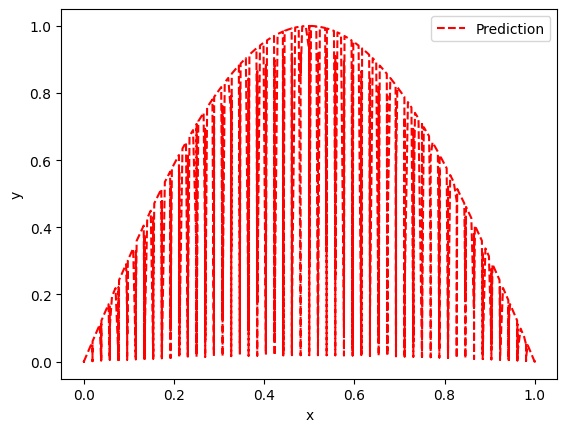

In [230]:
# 1D plot the training points
# if train_state.X_test.shape[1] == 1:
idx = np.argsort(train_state.X_test[:, 0])
X = train_state.X_test[idx, 0]
plt.figure()
for i in range(y_dim):
    if y_train is not None:
        plt.plot(train_state.X_train[:, 0], y_train[:, i], "ok", label="Train")

# 1D plot the validation points
if y_test is not None:
    plt.plot(X, y_test[idx, i], "-k", label="True", alpha=0.2)

# 1D plot the predicted curve
plt.plot(X, best_y[idx, i], "--r", label="Prediction")


plt.xlabel("x")
plt.ylabel("y")
plt.legend()

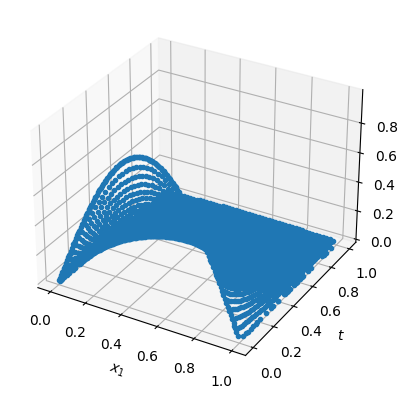

In [254]:
# elif train_state.X_test.shape[1] == 2:
from mpl_toolkits.mplot3d import Axes3D
for i in range(y_dim):
    plt.figure()
    ax = plt.axes(projection=Axes3D.name)
    ax.plot3D(
        train_state.X_test[:, 0],
        train_state.X_test[:, 1],
        best_y[:, i],
        ".",
    )
    ax.set_xlabel("$x_1$")
    ax.set_ylabel("$t$") #originally named x_2
    ax.set_zlabel("$y$")


In [244]:
print(train_state.X_test.shape)
print(train_state.X_test[:,0].shape)
print(train_state.X_test[:,1].shape)

# x[:,0]) is x-coordinate and the second component
# x[:,1] is the t-coordinate

(2790, 2)
(2790,)
(2790,)


In [258]:
print(train_state.X_test[:,0])
print(train_state.X_test[:,1])

[1.         1.         0.         ... 0.9423077  0.96153843 0.9807692 ]
[0.109375  0.1328125 0.234375  ... 0.02      0.02      0.02     ]


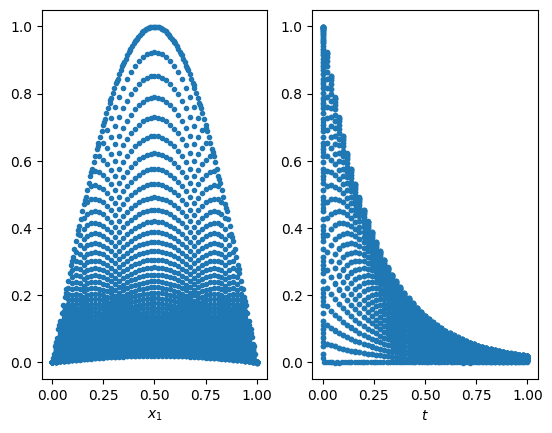

In [256]:
# elif train_state.X_test.shape[1] == 2:
for i in range(y_dim):
    fig, ax = plt.subplots(1,2)
    ax[0].plot(
        train_state.X_test[:, 0],

        best_y[:, i],
        ".",
    )
    ax[1].plot(
        train_state.X_test[:, 1],

        best_y[:, i],
        ".",
    )

    ax[0].set_xlabel("$x_1$")
    ax[1].set_xlabel("$t$")



In [ ]:
dde.utils.external.save_best_state(train_state, 'train.dat', 'test.dat')

Saving training data to train.dat ...
Saving test data to test.dat ...


# Reaction-diffusion PDE

### Imports

In [60]:
import deepxde as dde
from deepxde.backend import tf
import numpy as np

## PDE definition

$\frac{{\partial y}}{{\partial t}} = d\frac{{\partial^2 y}}{{\partial x^2}} + e^{-t}\left(3\sin^2(x^2) + 8\sin^3(x^3) + 15\sin^4(x^4) + 63\sin^8(x^8)\right)$

with initial conditions:

$y(t, -\pi) = y(t, \pi) = 0, \quad t \in [0, 1]$

We also specify the following parameters for the equation:

$d=1$

The exact solution is

$y(x,t) = e^{-t}(\sin(x) + \sin(2x^2) + \sin(3x^3) + \sin(4x^4) + \sin(8x^8))$

First, express the PDE residual:

The first argument to pde is the 2 dimensional vector where the first component(x[:, 0]) is the x
-coordinate, and the second component(x[:, 1]) is the t
-coordinate. The second argument is the network output, i.e., the solution u(x)
, but here we use y as the name of the variable.

In [61]:
def pde(x, y):
    dy_t = dde.grad.jacobian(y, x, i=0, j=1)
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    d = 1
    # Backend tensorflow.compact.v1 or tensorflow
    return (
        dy_t
        - d * dy_xx # diffusion component
        - tf.exp(-x[:, 1:]) # first column presumably space, second time
        * (
            3 * tf.sin(2 * x[:, 0:1]) / 2
            + 8 * tf.sin(3 * x[:, 0:1]) / 3
            + 15 * tf.sin(4 * x[:, 0:1]) / 4
            + 63 * tf.sin(8 * x[:, 0:1]) / 8
        )
    )

Exact solution of the PDE

In [62]:
def func(x):
    return np.exp(-x[:, 1:]) * (
        np.sin(x[:, 0:1])
        + np.sin(2 * x[:, 0:1]) / 2
        + np.sin(3 * x[:, 0:1]) / 3
        + np.sin(4 * x[:, 0:1]) / 4
        + np.sin(8 * x[:, 0:1]) / 8
    )

Define the spatial domain and timecourse

Now we can define a computational geometry and time domain. We can use a built-in class Interval and TimeDomain and we combine both the domains using GeometryXTime as follows

In [63]:
geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 0.99)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

In [64]:
data = dde.data.TimePDE(
    geomtime, pde, [], num_domain=320, solution=func, num_test=80000
)

The number 320 is the number of training residual points sampled inside the domain, and the number 80000 is the number of points sampled inside the domain for testing the PDE loss.

Next, we choose the network. Here, we use a fully connected neural network of depth 7 (i.e., 6 hidden layers) and width 30:

In [65]:
layer_size = [2] + [30] * 6 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

Then we construct a function that satisfies both the initial and the boundary conditions to tansform the network output. In this case,
$t(π2−x2)y+sinx+sin2x2+sin3x3+sin4x4+sin8x8$

 is used. If $t=0$, the initial condition is recovered. When $x=−π$ or $π$
, the boundary condition is recovered. Hence the initial and boundary conditions are both hard conditions.

In [66]:
def output_transform(x, y):
    return (
        x[:, 1:2] * (np.pi ** 2 - x[:, 0:1] ** 2) * y
        + tf.sin(x[:, 0:1])
        + tf.sin(2 * x[:, 0:1]) / 2
        + tf.sin(3 * x[:, 0:1]) / 3
        + tf.sin(4 * x[:, 0:1]) / 4
        + tf.sin(8 * x[:, 0:1]) / 8
    )

net.apply_output_transform(output_transform)

Now, we have the PDE problem and the network. We build a Model and choose the optimizer and learning rate. We then train the model for 20000 iterations.

In [ ]:
!apt install imagemagick

In [12]:
# checkpointer = dde.callbacks.ModelCheckpoint(
#     "RDmodel/model.ckpt", verbose=1, save_better_only=True
# )
# # ImageMagick (https://imagemagick.org/) is required to generate the movie.
# movie = dde.callbacks.MovieDumper(
#     "RDmodel/movie", [-1], [1], period=320, save_spectrum=True, y_reference=func
# )

In [67]:
# model = dde.Model(data, net)
# model.compile("adam", lr=1e-3, metrics=["l2 relative error"])
# losshistory, train_state = model.train(iterations=20000, callbacks=[checkpointer, movie]
# )

model = dde.Model(data, net)
model.compile("adam", lr=1e-3, metrics=["l2 relative error"])
losshistory, train_state = model.train(iterations=20000)

Compiling model...
Building feed-forward neural network...
'build' took 0.122826 s

'compile' took 1.565646 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [2.96e+01]    [2.99e+01]    [1.83e+00]    
1000      [4.07e-02]    [3.89e-02]    [6.48e-01]    
2000      [1.35e-02]    [1.32e-02]    [4.24e-01]    
3000      [3.24e-03]    [3.41e-03]    [2.71e-01]    
4000      [1.90e-03]    [2.09e-03]    [1.87e-01]    
5000      [9.70e-04]    [1.08e-03]    [1.44e-01]    
6000      [1.31e-02]    [1.34e-02]    [1.29e-01]    
7000      [5.61e-04]    [6.34e-04]    [9.47e-02]    
8000      [4.47e-04]    [5.09e-04]    [7.96e-02]    
9000      [3.70e-03]    [3.80e-03]    [8.40e-02]    
10000     [2.23e-02]    [2.27e-02]    [4.70e-02]    
11000     [2.08e-03]    [2.18e-03]    [5.15e-02]    
12000     [2.40e-04]    [2.76e-04]    [5.03e-02]    
13000     [2.56e-04]    [2.90e-04]    [4.63e-02]    
14000     [9.07e-03]    [9.26e-03]    [5.95e-02]    
15000     [6.05e-04]  

In [68]:
def _pack_data(train_state):
    def merge_values(values):
        if values is None:
            return None
        return np.hstack(values) if isinstance(values, (list, tuple)) else values

    y_train = merge_values(train_state.y_train)
    y_test = merge_values(train_state.y_test)
    best_y = merge_values(train_state.best_y)
    best_ystd = merge_values(train_state.best_ystd)
    return y_train, y_test, best_y, best_ystd


In [69]:
y_train, y_test, best_y, best_ystd = _pack_data(train_state)
y_dim = best_y.shape[1]

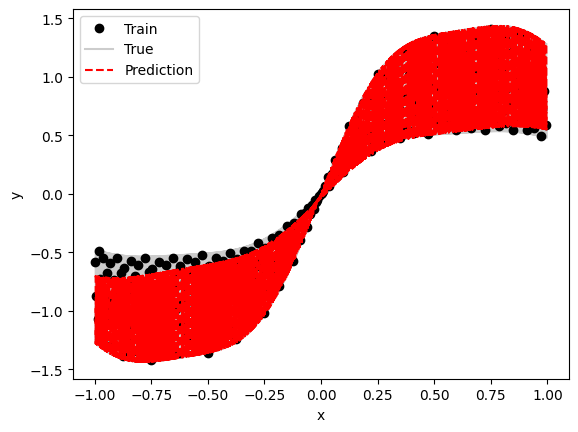

In [71]:
# 1D plot the training points
# if train_state.X_test.shape[1] == 1:
idx = np.argsort(train_state.X_test[:, 0])
X = train_state.X_test[idx, 0]
plt.figure()
for i in range(y_dim):
    if y_train is not None:
        plt.plot(train_state.X_train[:, 0], y_train[:, i], "ok", label="Train")

# 1D plot the validation points
if y_test is not None:
    plt.plot(X, y_test[idx, i], "-k", label="True", alpha=0.2)

# 1D plot the predicted curve
plt.plot(X, best_y[idx, i], "--r", label="Prediction")


plt.xlabel("x")
plt.ylabel("y")
plt.legend()

In [73]:
dde.utils.external.save_best_state(train_state, 'train.dat', 'test.dat')

Saving training data to train.dat ...
Saving test data to test.dat ...


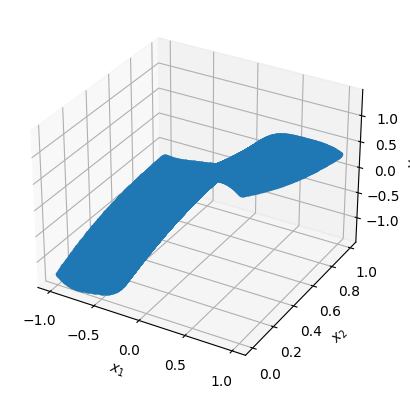

In [24]:
dde.utils.external.plot_best_state(train_state)

In [25]:
print(train_state)

Saving loss history to /content/loss.dat ...
Saving training data to /content/train.dat ...
Saving test data to /content/test.dat ...


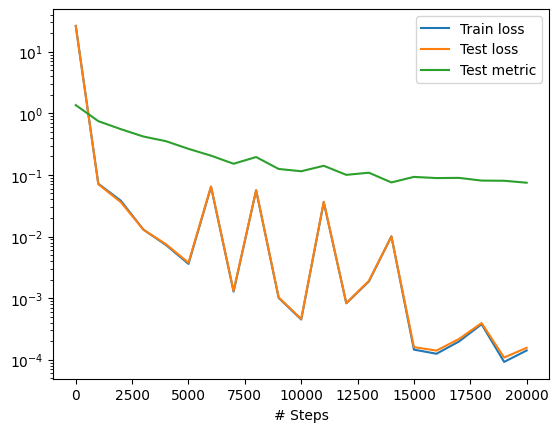

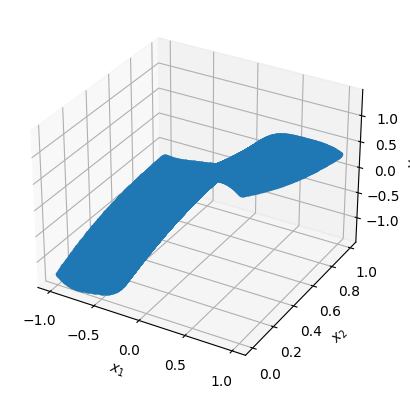

In [19]:
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

## Inverse problem for a 2 component reaction diffusion PDE

In [ ]:
import deepxde as dde
import numpy as np

We will solve an inverse problem for diffusion-reaction systems for unknowns $D$
 and $kf$
:\
$
\frac{{\partial C_A}}{{\partial t}} = D\frac{{\partial^2 C_A}}{{\partial x^2}} - k_f C_A C_B^2, \\
\frac{{\partial C_B}}{{\partial t}} = D\frac{{\partial^2 C_B}}{{\partial x^2}} - 2k_f C_A C_B^2$

for the initial conditions $x∈[0,1]$
 and $t∈[0,10]$:

$C_A(x, 0) = C_B(x, 0) = e^{-20x}$

and boundary conditions:\
$C_A(0, t) = C_B(0, t) = 1 \\
C_A(1, t) = C_B(1, t) = 0$

Define the initial guesses of $D$ and $k_f$ as 0.05 and 1 (real values are 0.002 and 0.1)

In [ ]:
kf = dde.Variable(0.05)
D = dde.Variable(1.0)

We define the computational geometries by using the built-in Interval and TimeDomain classes and combining them with GeometryXTime:

In [ ]:
geom = dde.geometry.Interval(0, 1)
timedomain = dde.geometry.TimeDomain(0, 10)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

Then define a function for the PDE system:

In [ ]:
def pde(x, y):
    ca, cb = y[:, 0:1], y[:, 1:2]
    dca_t = dde.grad.jacobian(y, x, i=0, j=1)
    dca_xx = dde.grad.hessian(y, x, component=0, i=0, j=0)
    dcb_t = dde.grad.jacobian(y, x, i=1, j=1)
    dcb_xx = dde.grad.hessian(y, x, component=1, i=0, j=0)
    eq_a = dca_t - 1e-3 * D * dca_xx + kf * ca * cb ** 2
    eq_b = dcb_t - 1e-3 * D * dcb_xx + 2 * kf * ca * cb ** 2
    return [eq_a, eq_b]

Here, the first parameter is: \\

$t$
which is a coordinate, and it is represented by the arg $x$ as. The second arg $y$ contains $C_A$
 and $C_B$. Then, we use

```
dde.grad.jacobian
```
and
```
dde.grad.hessian
```
to represent the desired first and second order partial derivatives.

Next, we consider the Dirichlet boundary conditions:

In [ ]:
 def fun_bc(x):
    return 1 - x[:, 0:1]

In [ ]:
bc_a = dde.icbc.DirichletBC(
    geomtime, fun_bc, lambda _, on_boundary: on_boundary, component=0
)
bc_b = dde.icbc.DirichletBC(
    geomtime, fun_bc, lambda _, on_boundary: on_boundary, component=1
)

And the initial conditions $x∈[0,1]$
 and $t∈[0,10]$:

$C_A(x, 0) = C_B(x, 0) = e^{-20x}$

In [ ]:
def fun_init(x):
    return np.exp(-20 * x[:, 0:1])

In [ ]:
ic1 = dde.icbc.IC(
    geomtime, fun_init, lambda _, on_initial: on_initial, component=0
)
ic2 = dde.icbc.IC(
    geomtime, fun_init, lambda _, on_initial: on_initial, component=1
)

Organising the training data

First define a function to load the training data, which was solved with:
$D = 2⋅10−3,\\
 k_f= 0.1
$

In [ ]:
def gen_traindata():
    data = np.load("/content/PatternLearning/PINNs/Lu_2021_deepXDE/deep_xde_datasets/reaction.npz")
    t, x, ca, cb = data["t"], data["x"], data["Ca"], data["Cb"]
    X, T = np.meshgrid(x, t)
    X = np.reshape(X, (-1, 1))
    T = np.reshape(T, (-1, 1))
    Ca = np.reshape(ca, (-1, 1))
    Cb = np.reshape(cb, (-1, 1))
    return np.hstack((X, T)), Ca, Cb

In [ ]:
observe_x, Ca, Cb = gen_traindata()
observe_y1 = dde.icbc.PointSetBC(observe_x, Ca, component=0)
observe_y2 = dde.icbc.PointSetBC(observe_x, Cb, component=1)

Now, we can define the TimePDE problem as follows:

In [ ]:
data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc_a, bc_b, ic1, ic2, observe_y1, observe_y2],
    num_domain=2000,
    num_boundary=100,
    num_initial=100,
    anchors=observe_x,
    num_test=50000,
)

We have 2000 training residual points in the domain, 100 points on the boundary, 100 points for the initial conditions, and 50000 to test the PDE residual.

```
anchors
```

specifies the training points

Create the network

In [ ]:
net = dde.nn.FNN([2] + [20] * 3 + [2], "tanh", "Glorot uniform")

This network has two inputs, one for the $t$
-coordinate and one for the $x$
-coordinate, and three hidden layers with 20 neurons each. The output layer has two outputs, one for $C_A$
 and one for $C_B$
. We also choose tanh to be the activation function, and the initializer is Glorot uniform.

Now, we create the Model and specify the optimizer, learning rate, and external_trainable_variables. We also output the values of $D$
 and $k_f$
 every 1000 iterations.

In [ ]:
model = dde.Model(data, net)
model.compile("adam", lr=0.001, external_trainable_variables=[kf, D])
variable = dde.callbacks.VariableValue([kf, D], period=1000, filename="variables.dat")

Compiling model...
Building feed-forward neural network...
'build' took 0.067786 s

'compile' took 0.973962 s



Train the network (80000 epochs)

Training model...

Step      Train loss                                                                          Test loss                                                                           Test metric
0         [5.78e-03, 1.10e-02, 3.40e-01, 1.23e+00, 3.47e-02, 3.33e-02, 6.91e-02, 4.28e-01]    [5.52e-03, 1.05e-02, 3.40e-01, 1.23e+00, 3.47e-02, 3.33e-02, 6.91e-02, 4.28e-01]    []  
1000      [2.14e-04, 2.35e-04, 4.40e-04, 4.17e-04, 7.96e-04, 7.55e-04, 2.70e-04, 2.19e-04]    [1.59e-04, 1.80e-04, 4.40e-04, 4.17e-04, 7.96e-04, 7.55e-04, 2.70e-04, 2.19e-04]    []  
2000      [5.13e-05, 6.33e-05, 1.11e-04, 1.18e-04, 1.90e-04, 1.61e-04, 1.06e-04, 1.79e-04]    [3.74e-05, 4.88e-05, 1.11e-04, 1.18e-04, 1.90e-04, 1.61e-04, 1.06e-04, 1.79e-04]    []  
3000      [2.95e-05, 4.41e-05, 5.08e-05, 5.72e-05, 7.93e-05, 5.37e-05, 3.61e-05, 8.54e-05]    [2.54e-05, 3.62e-05, 5.08e-05, 5.72e-05, 7.93e-05, 5.37e-05, 3.61e-05, 8.54e-05]    []  
4000      [2.74e-05, 3.45e-05, 2.51e-05, 2.98e-05, 4.18e-05

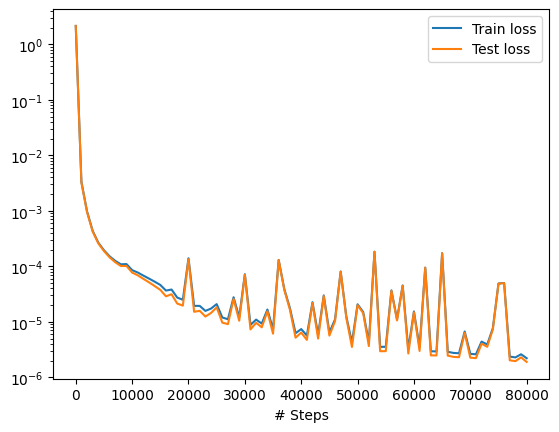

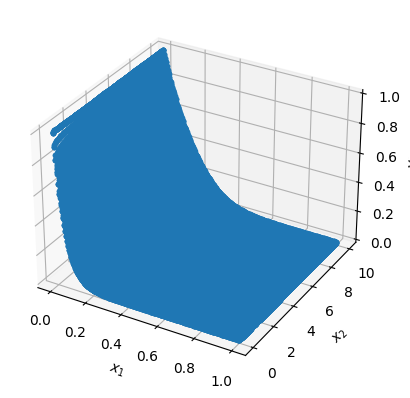

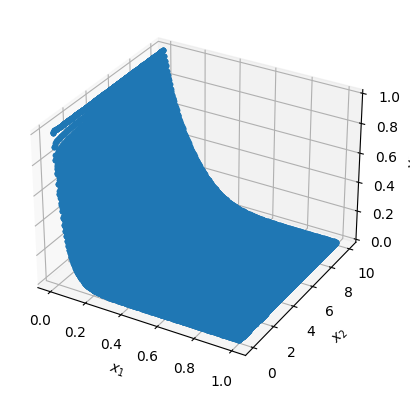

In [ ]:
losshistory, train_state = model.train(iterations=80000, callbacks=[variable])
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

Check the learned variables

In [ ]:
learned_vars = np.genfromtxt('variables.dat',
                     skip_header=1,
                     skip_footer=1,
                     names=True,
                     dtype=None,
                     delimiter=' ')
print(learned_vars)
print(learned_vars[-1])

In [ ]:
converted_arr = np.array([(learned_vars[i][0], (float(learned_vars[i][1][1:-1]), float(learned_vars[i][2][:-1]))) for i in range(len(learned_vars))])

print(converted_arr)

In [ ]:
print(converted_arr[-1][1])
kf_learned, D_learned = converted_arr[-1][1][0], converted_arr[-1][1][1]

(0.0975, 1.99)


In [ ]:
print(kf_learned, D_learned)

0.0975 1.99


# Reaction diffusion (Schnakenberg)

## Imports

In [ ]:
import deepxde as dde
from deepxde.backend import tf
import numpy as np

Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Instructions for updating:
non-resource variables are not supported in the long term

